<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance5_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 5. Modelo final

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

En esta etapa el objetivo es construir múltiples modelos con lafinalidad de explorar y evaluar cuál de ellos proporciona el mejor rendimiento para resolver el problema que nos fue asignado. El ejercicio se centra en la elección de los modelos, su entrenamiento y configuración de hiperparámetros para mejorar el desempeño.

## 0. Librerías

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time

In [ ]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Librerías para la sección de modelos supervisados y ensambles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import BaggingClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from IPython.display import display_html

In [ ]:
# El siguiente bloque se agregó para poder leer los archivos drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

In [ ]:
# Función para mostrar los DataFrames uno junto al otro con estilos
def display_side_by_side(dfs, captions, color='lightgreen', axis=0):
    html_str = ''
    for caption, df in zip(captions, dfs):
        html_str += '<div style="display: inline-block; padding: 10px;">'
        html_str += f'<h3>{caption}</h3>'
        html_str += df.style.highlight_max(color=color, axis=axis).render()
        html_str += '</div>'
    display_html(html_str, raw=True)

## 1. Preparación de datos

Se aplica el pre procesamiento de los datos que se ha trabajado en semanas anteriores

In [ ]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [ ]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)
df = df.dropna(axis=1, how='all')

In [ ]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [ ]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar
df = df.drop(columns=columnas_a_eliminar)

In [ ]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [ ]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [ ]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [ ]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

In [ ]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [ ]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

In [ ]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

In [ ]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

In [ ]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [ ]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsonorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [ ]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [ ]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

In [ ]:
# Hacemos listas de las variables ordinales
cat_orginales= ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO','TRASTORNO_MAYOR_DIAGNOSTICO',
                'Riesgo_suicidio','Sintomas_ansiosos']

In [ ]:
# Creamos una copia del dataframe
df_TC=df_T.copy()

In [ ]:
# Crear el encoder ordinal
encoder_1 = OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                     "Estudios universitarios no terminados", "Licenciatura", "Posgrado"]], dtype=int)
encoder_2 = OrdinalEncoder(categories=[["Distimia","Trastorno depresivo episodio único ",
                                        "Trastorno depresivo mayor recidivante"]], dtype=int)
encoder_3 = OrdinalEncoder(categories=[["0","TRASTORNO DEPRESIVO MAYOR","TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO O PRIMER EPISODIO",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE O RECIDIVANTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE O SEVERO"]], dtype=int)
encoder_4 = OrdinalEncoder(categories=[["Leve","Moderado","Alto"]], dtype=int)
encoder_5 = OrdinalEncoder(categories=[["Leve","Moderado-Grave"]], dtype=int)
encoder_6 = OrdinalEncoder(categories=[["Primera aparición sin antecedente","Indistinguible del pasado",
                                        "Recurrencia condición previa",
                                        "Significativamente diferente de condición previa",
                                        "Exageración de trastorno crónico"]], dtype=int)

# Ajustar y transformar los datos
df_TC['ESCOLARIDAD__JEFE_FAMILIA_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD__JEFE_FAMILIA']])
df_TC['ESCOLARIDAD_MAXIMA_PX_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD_MAXIMA_PX']])
df_TC['DX_PRIMARIO_encoded'] = encoder_2.fit_transform(df_TC[['DX_PRIMARIO']])
df_TC['TRASTORNO_MAYOR_DIAGNOSTICO_encoded'] = encoder_3.fit_transform(df_TC[['TRASTORNO_MAYOR_DIAGNOSTICO']])
df_TC['Riesgo_suicidio_encoded'] = encoder_4.fit_transform(df_TC[['Riesgo_suicidio']])
df_TC['Sintomas_ansiosos_encoded'] = encoder_5.fit_transform(df_TC[['Sintomas_ansiosos']])
df_TC['CONDICION_ACTUAL_encoded'] = encoder_6.fit_transform(df_TC[['CONDICION_ACTUAL']])

In [ ]:
# Eliminamos estas características originales
df_TC = df_TC.drop(["ESCOLARIDAD__JEFE_FAMILIA","ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","TRASTORNO_MAYOR_DIAGNOSTICO",
                "Riesgo_suicidio","Sintomas_ansiosos","CONDICION_ACTUAL"],
             axis=1)

In [ ]:
# Hacemos listas de las variables no ordinales
cat_no_orginales= ['SEXO', 'ESTADO_civil', 'RELIGION','PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

In [ ]:
# Creamos una copia del ultimo dataframe
df_TCL=df_TC.copy()

In [ ]:
# Inicializar el LabelEncoder
encoder = LabelEncoder()

# Iterar sobre las columnas y aplicar el LabelEncoder
for col in cat_no_orginales:
    df_TCL[col] = encoder.fit_transform(df_TCL[col])

In [ ]:
# Creamos una copia del ultimo dataframe
df_TC_encoded=df_TC.copy()

In [ ]:
# Aplicar Get_dummies asegurando de eliminar la primera categoría
df_TC_encoded = pd.get_dummies(df_TC_encoded, columns=cat_no_orginales, drop_first=True)

In [ ]:
# Generamos la base con las características y la variable de salida
X1 = df_TC_encoded.drop(columns=['Sintomas_ansiosos_encoded'])
Y1 = df_TC_encoded['Sintomas_ansiosos_encoded']
Xtv1, Xtest1, ytv1, ytest1 = train_test_split(X1, Y1, train_size = 0.9, random_state = 0)

### 1.1 Desbalanceo

#### 1.1.1 Comparativa de métodos de balanceo - Conservar

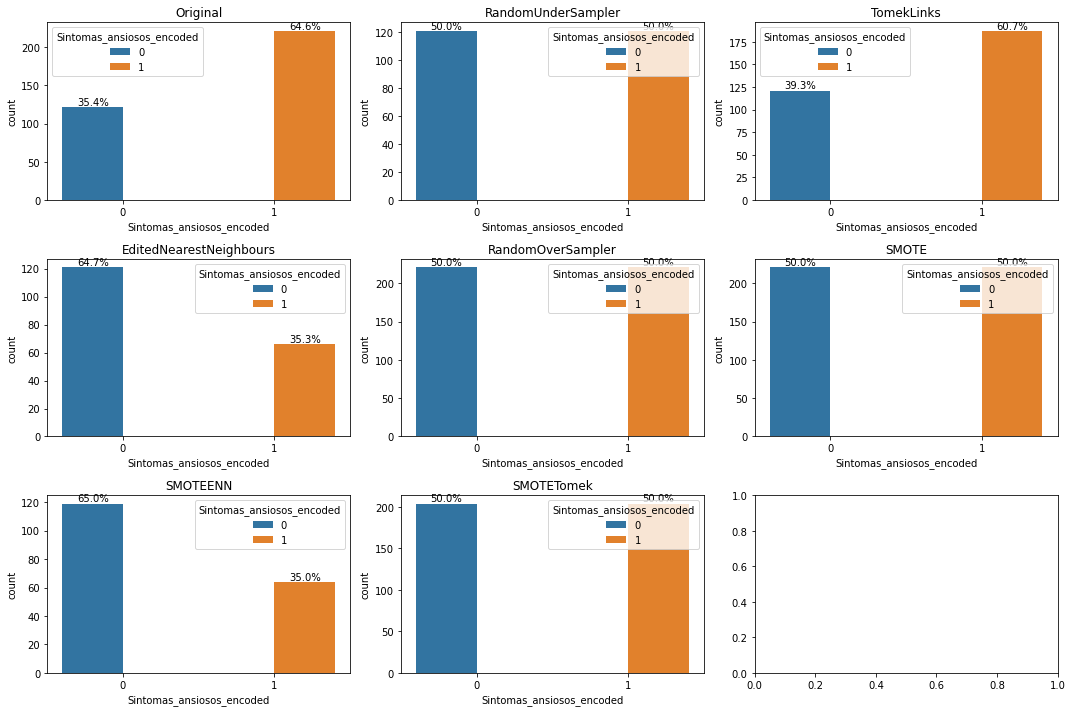

In [ ]:
# Balanceo del dataset

# Crear un DataFrame con Xtv1 y ytv1
df_train = pd.concat([Xtv1, ytv1], axis=1)

models = [
    ('Original', df_train),
    ('RandomUnderSampler', RandomUnderSampler(sampling_strategy='auto')),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('EditedNearestNeighbours', EditedNearestNeighbours(sampling_strategy='auto')),
    ('RandomOverSampler', RandomOverSampler(sampling_strategy='auto')),
    ('SMOTE', SMOTE(sampling_strategy='auto')),
    ('SMOTEENN', SMOTEENN(sampling_strategy='auto')),
    ('SMOTETomek', SMOTETomek(sampling_strategy='auto')),
]

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax = ax.ravel()

for i, (name, model) in enumerate(models):
    if name == 'Original':
        data = df_train
    else:
        data = df_train.copy()

        # ajusta el modelo
        Xr, yr = model.fit_resample(data.drop(columns='Sintomas_ansiosos_encoded'), data['Sintomas_ansiosos_encoded'])
        data = pd.concat([Xr, yr], axis=1)

    sns.countplot(data=data, x='Sintomas_ansiosos_encoded', ax=ax[i], hue='Sintomas_ansiosos_encoded')
    # calcula el porcentaje
    total = len(data)
    for p in ax[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax[i].annotate(percentage, (x, y), ha='center', va='bottom')
    ax[i].set_title(name)

plt.tight_layout()
plt.show()

El gráfico anterior nos permite observar el efecto de cada uno de nuestros métodos en las clases. RandomOverSampler, SMOTE y SMOTETomek tienen la ventaja de que no eliminan registros, sino que incrementan los de la clase negativa, lo cual es una consideración importante en nuestros registros. En entregas pasadas se hizo el análisis del efecto de algunos de estos métodos en nuestros modelos.

## **2 Ensambles**

### **2.1 Baseline**

Generamos un modelo Dummy que predice siempre la clase positiva. Esto para tener una referencia con la cual comparar el resto de modelos.

In [ ]:
# Creamos un modelo
start_time = time.time()
dummy_clf = DummyClassifier(strategy='most_frequent', random_state= 0)

# Se ajusta el modelo a los datos de entrenamiento
dummy_clf.fit(Xtv1, ytv1)
tiempo_fit_dummy = time.time() - start_time

preds_dum_tv = dummy_clf.predict_proba(Xtv1)

### **2.2 Modelos de Ensamble Adicionales**

Probamos algunos modelos de ensamble adicionales recomendados en los comentarios de la tarea

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
etc = ExtraTreesClassifier(class_weight='balanced', random_state=0)

# Se ajusta el modelo
etc.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_etc = end_time_fit - start_time_fit

preds_etc_tv = etc.predict_proba(Xtv1)[:, 1]
preds_etc_test = etc.predict_proba(Xtest1)[:, 1]

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
gbc = GradientBoostingClassifier(random_state=0)

# Se ajusta el modelo
gbc.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_gbc = end_time_fit - start_time_fit

preds_gbc_tv = gbc.predict_proba(Xtv1)[:, 1]
preds_gbc_test = gbc.predict_proba(Xtest1)[:, 1]

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
abc = AdaBoostClassifier(random_state=0)

# Se ajusta el modelo
abc.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_abc = end_time_fit - start_time_fit

preds_abc_tv = abc.predict_proba(Xtv1)[:, 1]
preds_abc_test = abc.predict_proba(Xtest1)[:, 1]

In [ ]:
# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento
ytv1_pred_dum = cross_val_predict(dummy_clf, Xtv1, ytv1, cv=5)
recall_tv_dum = 0 # No se calcula ya que recall evalua la tasa de verdaderos positivos y
                    #nuestro Dummy genera un 100% de positivos.
recall_tv_macro_dum = 0
f1_tv_dum = f1_score(ytv1, ytv1_pred_dum, average='binary')

ytv1_pred_etc = cross_val_predict(etc, Xtv1, ytv1, cv=5)
recall_tv_etc = recall_score(ytv1, ytv1_pred_etc, average='binary')
recall_tv_macro_etc = recall_score(ytv1, ytv1_pred_etc, average='macro')
f1_tv_etc = f1_score(ytv1, ytv1_pred_etc, average='binary')

ytv1_pred_gbc = cross_val_predict(gbc, Xtv1, ytv1, cv=5)
recall_tv_gbc = recall_score(ytv1, ytv1_pred_gbc, average='binary')
recall_tv_macro_gbc = recall_score(ytv1, ytv1_pred_gbc, average='macro')
f1_tv_gbc = f1_score(ytv1, ytv1_pred_gbc, average='binary')

ytv1_pred_abc = cross_val_predict(abc, Xtv1, ytv1, cv=5)
recall_tv_abc = recall_score(ytv1, ytv1_pred_abc, average='binary')
recall_tv_macro_abc = recall_score(ytv1, ytv1_pred_abc, average='macro')
f1_tv_abc = f1_score(ytv1, ytv1_pred_abc, average='binary')

# Creamos cuadro con los resultados de conjunto de entrenamiento
cuadro1 = {
    'Modelo': ['Dummy', 'ETC', 'GBC','ABC'],
    'Recall': [recall_tv_dum, recall_tv_etc, recall_tv_gbc, recall_tv_abc],
    'Recall Macro': [recall_tv_macro_dum, recall_tv_macro_etc,recall_tv_macro_gbc,recall_tv_macro_abc],
    'F1 Score': [f1_tv_dum, f1_tv_etc,f1_tv_gbc,f1_tv_abc],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_etc, tiempo_fit_gbc, tiempo_fit_abc]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_dum = cross_val_predict(dummy_clf, Xtest1, ytest1, cv=5)
recall_test_dum = 0
recall_test_macro_dum = 0
f1_test_dum = f1_score(ytest1, ytest1_pred_dum, average='binary')

ytest1_pred_etc = cross_val_predict(etc, Xtest1, ytest1, cv=5)
recall_test_etc = recall_score(ytest1, ytest1_pred_etc, average='binary')
recall_test_macro_etc = recall_score(ytest1, ytest1_pred_etc, average='macro')
f1_test_etc = f1_score(ytest1, ytest1_pred_etc, average='binary')

ytest1_pred_gbc = cross_val_predict(gbc, Xtest1, ytest1, cv=5)
recall_test_gbc = recall_score(ytest1, ytest1_pred_gbc, average='binary')
recall_test_macro_gbc = recall_score(ytest1, ytest1_pred_gbc, average='macro')
f1_test_gbc = f1_score(ytest1, ytest1_pred_gbc, average='binary')

ytest1_pred_abc = cross_val_predict(abc, Xtest1, ytest1, cv=5)
recall_test_abc = recall_score(ytest1, ytest1_pred_abc, average='binary')
recall_test_macro_abc = recall_score(ytest1, ytest1_pred_abc, average='macro')
f1_test_abc = f1_score(ytest1, ytest1_pred_abc, average='binary')


# Creamos cuadro con los resultados de conjunto de prueba
cuadro2 = {
    'Modelo': ['Dummy', 'ETC', 'GBC','ABC'],
    'Recall': [recall_test_dum, recall_test_etc,recall_test_gbc,recall_test_abc],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_etc,recall_test_macro_gbc,recall_test_macro_abc],
    'F1 Score': [f1_test_dum, f1_test_etc,f1_test_gbc,f1_test_abc],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_etc, tiempo_fit_gbc, tiempo_fit_abc]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.785080,0.000291
ETC,0.773756,0.531506,0.715481,0.063733
GBC,0.755656,0.534853,0.709130,0.062310
ABC,0.710407,0.537022,0.690110,0.125547
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
ETC,0.708333,0.497024,0.666667,0.063733
GBC,0.583333,0.434524,0.583333,0.062310
ABC,0.541667,0.485119,0.577778,0.125547


*Nota:* Para el modelo Dummy no se calcula recall ya que evalua la tasa de verdaderos positivos y nuestro Dummy genera un 100% de positivos y por tanto un recall de 1 y un recall macro de .50, lo cual no es comparable con los otros modelos.

### **2.3 Stacking**

Con esta técnica de ensamble probaremos regresión logística como meta-modelo y como características de entrada usaremos diferentes combinaciones de los mejores modelos supervisados que encontramos en la etapa anterior.

#### 2.3.1 Regresión logística y SVM

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# Se ajusta el modelo
reg.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_reg = end_time_fit - start_time_fit

preds_reg_tv = reg.predict_proba(Xtv1)[:, 1]
preds_reg_test = reg.predict_proba(Xtest1)[:, 1]

En la entrega anterior el modelo SVM seleccionado fue con el submuestreo sin embargo lo consideraremos para hacer el modelo de ensamble con la base original.

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# Se ajusta el modelo
svm.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_svm = end_time_fit - start_time_fit

preds_svm_tv = svm.predict_proba(Xtv1)[:, 1]
preds_svm_test = svm.predict_proba(Xtest1)[:, 1]


In [ ]:
# Creamos el conjunto de datos para el ensamble
stacked_tv = np.column_stack((preds_reg_tv, preds_svm_tv))
stacked_test = np.column_stack((preds_reg_test, preds_svm_test))

In [ ]:
# Definir los modelos
start_time = time.time()
ensamble1 = LogisticRegression()

# Medir el tiempo de ajuste del ensamble
ensamble1.fit(stacked_tv, ytv1)
tiempo_fit_ensamble1 = time.time() - start_time


# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento
ytv1_pred_reg = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv_reg = recall_score(ytv1, ytv1_pred_reg, average='binary')
recall_tv_macro_reg = recall_score(ytv1, ytv1_pred_reg, average='macro')
f1_tv_reg = f1_score(ytv1, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv_svm = recall_score(ytv1, ytv1_pred_svm, average='binary')
recall_tv_macro_svm = recall_score(ytv1, ytv1_pred_svm, average='macro')
f1_tv_svm = f1_score(ytv1, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1 = ensamble1.predict(stacked_tv)
recall_tv_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='binary')
recall_tv_macro_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='macro')
f1_tv_ensamble1 = f1_score(ytv1, ytv1_pred_ensamble1, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_dum, recall_tv_reg, recall_tv_svm, recall_tv_ensamble1],
    'Recall Macro': [recall_tv_macro_dum, recall_tv_macro_reg, recall_tv_macro_svm, recall_tv_macro_ensamble1],
    'F1 Score': [f1_tv_dum, f1_tv_reg, f1_tv_svm, f1_tv_ensamble1],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_reg = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1 = ensamble1.predict(stacked_test)
recall_test_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='binary')
recall_test_macro_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='macro')
f1_test_ensamble1 = f1_score(ytest1, ytest1_pred_ensamble1, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg, recall_test_svm, recall_test_ensamble1],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1],
    'F1 Score': [f1_test_dum, f1_test_reg, f1_test_svm, f1_test_ensamble1],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

cuadro2_df = pd.DataFrame(cuadro2)

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.877828,0.641393,0.796715,0.003113
Dummy,0.000000,0.000000,0.785080,0.000291
SVM,0.610860,0.623612,0.675000,0.029109
Regression Logística,0.588235,0.554448,0.635697,0.008559
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Ensemble,0.791667,0.538690,0.716981,0.003113
Regression Logística,0.666667,0.547619,0.666667,0.008559
SVM,0.666667,0.511905,0.653061,0.029109


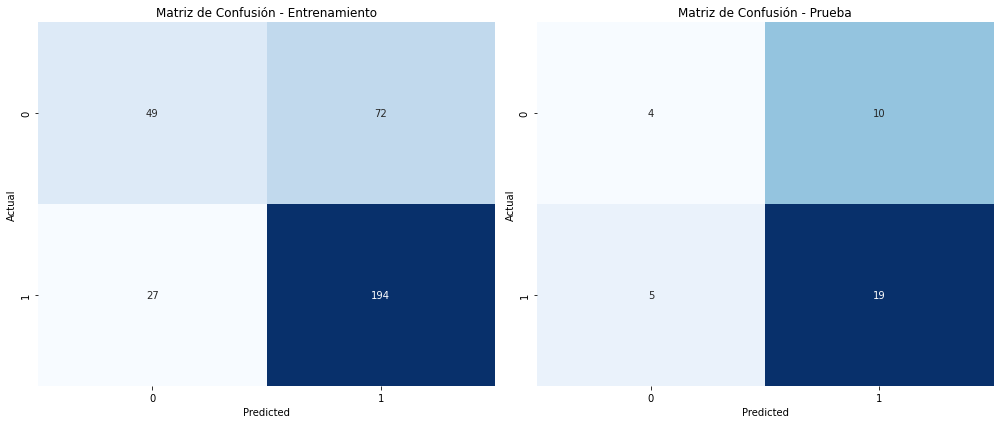

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv1_pred_ensamble1)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.3.2 XGBoost y Red Neuronal

In [ ]:
#Generamos la base con las características y la variable de salida
X2 = df_TCL.drop(columns=['Sintomas_ansiosos_encoded'])
Y2 = df_TCL['Sintomas_ansiosos_encoded']
Xtv2, Xtest2, ytv2, ytest2 = train_test_split(X2, Y2, train_size = 0.9, random_state = 0)

In [ ]:
# Definimos el modelo
start_time = time.time()
xgb = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 3, min_child_weight = 3, n_estimators = 50, subsample = 0.6, random_state=0)

# se ajusta el modelo
xgb.fit(Xtv2, ytv2)
tiempo_fit_xgb = time.time() - start_time

preds_xgb_tv = xgb.predict_proba(Xtv2)[:, 1]
preds_xgb_test = xgb.predict_proba(Xtest2)[:, 1]

In [ ]:
# Definimos el modelo
start_time = time.time()
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=0)

# se ajusta el modelo
red.fit(Xtv2, ytv2)
tiempo_fit_red = time.time() - start_time

preds_red_tv = red.predict(Xtv2).flatten()
preds_red_test = red.predict(Xtest2).flatten()

In [ ]:
# Creamos el conjunto de datos para el ensamble
stacked_tv2 = np.column_stack((preds_xgb_tv, preds_red_tv))
stacked_test2 = np.column_stack((preds_xgb_test, preds_red_test))

In [ ]:
# Definir los modelos
start_time = time.time()
ensamble2 = LogisticRegression()

# Medir el tiempo de ajuste del ensamble
ensamble2.fit(stacked_tv2, ytv2)
tiempo_fit_ensamble2 = time.time() - start_time

ytv2_pred_xgb = cross_val_predict(xgb, Xtv2, ytv2, cv=5)
recall_tv_xgb = recall_score(ytv2, ytv2_pred_xgb, average='binary')
recall_tv_macro_xgb = recall_score(ytv2, ytv2_pred_xgb, average='macro')
f1_tv_xgb = f1_score(ytv2, ytv2_pred_xgb, average='binary')

ytv2_pred_red = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv_red = recall_score(ytv2, ytv2_pred_red, average='binary')
recall_tv_macro_red = recall_score(ytv2, ytv2_pred_red, average='macro')
f1_tv_red = f1_score(ytv2, ytv2_pred_red, average='binary')

ytv2_pred_ensamble2 = ensamble2.predict(stacked_tv2)
recall_tv_ensamble2 = recall_score(ytv2, ytv2_pred_ensamble2, average='binary')
recall_tv_macro_ensamble2 = recall_score(ytv2, ytv2_pred_ensamble2, average='macro')
f1_tv_ensamble2 = f1_score(ytv2, ytv2_pred_ensamble2, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Xgboost', 'RED', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv_xgb, recall_tv_red, recall_tv_ensamble2],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro_xgb, recall_tv_macro_red, recall_tv_macro_ensamble2],
    'F1 Score': [f1_test_dum, f1_tv_xgb, f1_tv_red, f1_tv_ensamble2],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_xgb,tiempo_fit_red, tiempo_fit_ensamble2]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest2_pred_xgb = cross_val_predict(xgb, Xtest2, ytest2, cv=5)
recall_test_xgb = recall_score(ytest2, ytest2_pred_xgb, average='binary')
recall_test_macro_xgb = recall_score(ytest2, ytest2_pred_xgb, average='macro')
f1_test_xgb = f1_score(ytest2, ytest2_pred_xgb, average='binary')

ytest2_pred_red = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test_red = recall_score(ytest2, ytest2_pred_red, average='binary')
recall_test_macro_red = recall_score(ytest2, ytest2_pred_red, average='macro')
f1_test_red = f1_score(ytest2, ytest2_pred_red, average='binary')

ytest2_pred_ensamble2 = ensamble2.predict(stacked_test2)
recall_test_ensamble2 = recall_score(ytest2, ytest2_pred_ensamble2, average='binary')
recall_test_macro_ensamble2 = recall_score(ytest2, ytest2_pred_ensamble2, average='macro')
f1_test_ensamble2 = f1_score(ytest2, ytest2_pred_ensamble2, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Xgboost', 'RED', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_xgb, recall_test_red, recall_test_ensamble2],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_xgb, recall_test_macro_red, recall_test_macro_ensamble2],
    'F1 Score': [f1_test_dum, f1_test_xgb, f1_test_red, f1_test_ensamble2],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_xgb,tiempo_fit_red,tiempo_fit_ensamble2]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Mostrar ambos cuadros de resultados uno junto al otro con estilos
#display_side_by_side([cuadro1_df, cuadro2_df], ['Datos entrenamiento', 'Datos prueba'])

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)


,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.995475,0.981209,0.988764,0.002077
Dummy,0.000000,0.000000,0.774194,0.000291
Xgboost,0.805430,0.551475,0.735537,0.119493
RED,0.687783,0.509181,0.669604,0.270030
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Xgboost,1.000000,0.500000,0.774194,0.119493
RED,0.708333,0.532738,0.680000,0.270030
Ensemble,0.708333,0.497024,0.666667,0.002077


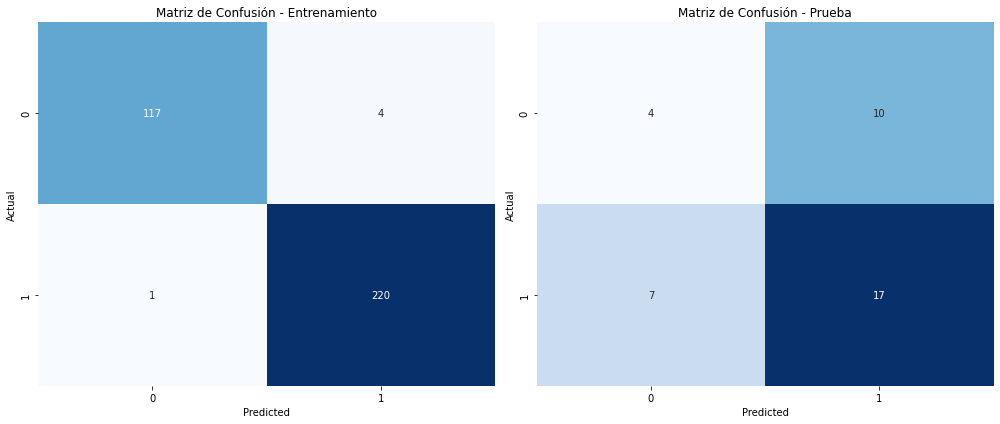

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv2, ytv2_pred_ensamble2)
cm_test = confusion_matrix(ytest2, ytest2_pred_ensamble2)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### **2.4 Bagging**

Ahora probamos con esta otra técnica en la que se entrenan múltiples modelos del mismo tipo en diferentes subconjuntos de datos, los cuales son generados por muestreo con reemplazo. Al final, el resultado depende de la votación mayoritaria de todos los modelos entrenados.

#### 2.4.1 Árbol de decisión

In [ ]:
# Definimos el modelo
start_time = time.time()
arbol = DecisionTreeClassifier(class_weight="balanced", criterion = 'entropy', max_depth = 7, max_features = 'auto',
                               min_samples_leaf = 7, min_samples_split = 15, random_state=0)

# se ajusta el modelo
arbol.fit(Xtv2, ytv2)
tiempo_fit_arbol = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble3 = BaggingClassifier(base_estimator=arbol, n_estimators=200, random_state=42)

# Medir el tiempo de ajuste del ensamble
ensamble3.fit(Xtv2, ytv2)
tiempo_fit_ensamble3 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv2_pred_arbol = cross_val_predict(arbol, Xtv2, ytv2, cv=5)
recall_tv_arbol = recall_score(ytv2, ytv2_pred_arbol, average='binary')
recall_tv_macro_arbol = recall_score(ytv2, ytv2_pred_arbol, average='macro')
f1_tv_arbol = f1_score(ytv2, ytv2_pred_arbol, average='binary')

ytv2_pred_ensamble3 = ensamble3.predict(Xtv2)
recall_tv_ensamble3 = recall_score(ytv2, ytv2_pred_ensamble3, average='binary')
recall_tv_macro_ensamble3 = recall_score(ytv2, ytv2_pred_ensamble3, average='macro')
f1_tv_ensamble3 = f1_score(ytv2, ytv2_pred_ensamble3, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Árbol', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv_arbol,  recall_tv_ensamble3],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro_arbol, recall_tv_macro_ensamble3],
    'F1 Score': [f1_test_dum, f1_tv_arbol, f1_tv_ensamble3],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_arbol,tiempo_fit_ensamble3]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest2_pred_arbol = cross_val_predict(arbol, Xtest2, ytest2, cv=5)
recall_test_arbol = recall_score(ytest2, ytest2_pred_arbol, average='binary')
recall_test_macro_arbol = recall_score(ytest2, ytest2_pred_arbol, average='macro')
f1_test_arbol = f1_score(ytest2, ytest2_pred_arbol, average='binary')

ytest2_pred_ensamble3 = ensamble3.predict(Xtest2)
recall_test_ensamble3 = recall_score(ytest2, ytest2_pred_ensamble3, average='binary')
recall_test_macro_ensamble3 = recall_score(ytest2, ytest2_pred_ensamble3, average='macro')
f1_test_ensamble3 = f1_score(ytest2, ytest2_pred_ensamble3, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Árbol', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_arbol, recall_test_ensamble3],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_arbol, recall_test_macro_ensamble3],
    'F1 Score': [f1_test_dum, f1_test_arbol, f1_test_ensamble3],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_arbol,tiempo_fit_ensamble3]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.864253,0.861879,0.890443,0.281767
Dummy,0.000000,0.000000,0.774194,0.000291
Árbol,0.538462,0.513032,0.592040,0.002813
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Árbol,0.708333,0.461310,0.653846,0.002813
Ensemble,0.583333,0.505952,0.608696,0.281767


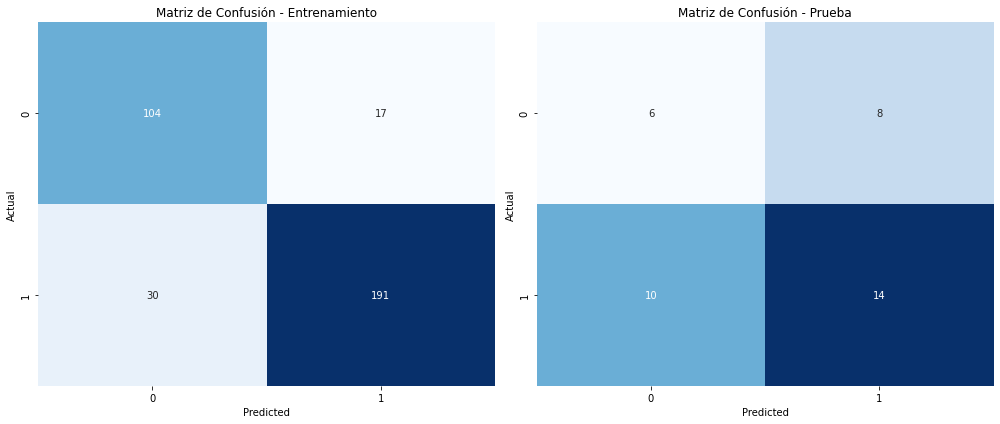

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv2, ytv2_pred_ensamble3)
cm_test = confusion_matrix(ytest2, ytest2_pred_ensamble3)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.4.2 Regresión Logística

In [ ]:
# Definimos el modelo
start_time = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# se ajusta el modelo
reg.fit(Xtv1, ytv1)
tiempo_fit_reg = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble4 = BaggingClassifier(base_estimator=reg, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble4.fit(Xtv1, ytv1)
tiempo_fit_ensamble4 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble4 = ensamble4.predict(Xtv1)
recall_tv_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='binary')
recall_tv_macro_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='macro')
f1_tv_ensamble4 = f1_score(ytv1, ytv_pred_ensamble4, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble4],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble4 = ensamble4.predict(Xtest1)
recall_test_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='binary')
recall_test_macro_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='macro')
f1_test_ensamble4 = f1_score(ytest1, ytest_pred_ensamble4, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble4],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Ensemble,0.733032,0.688830,0.760563,0.954059
Regresión logística,0.588235,0.554448,0.635697,0.007501
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Regresión logística,0.666667,0.547619,0.666667,0.007501
Ensemble,0.666667,0.547619,0.666667,0.954059


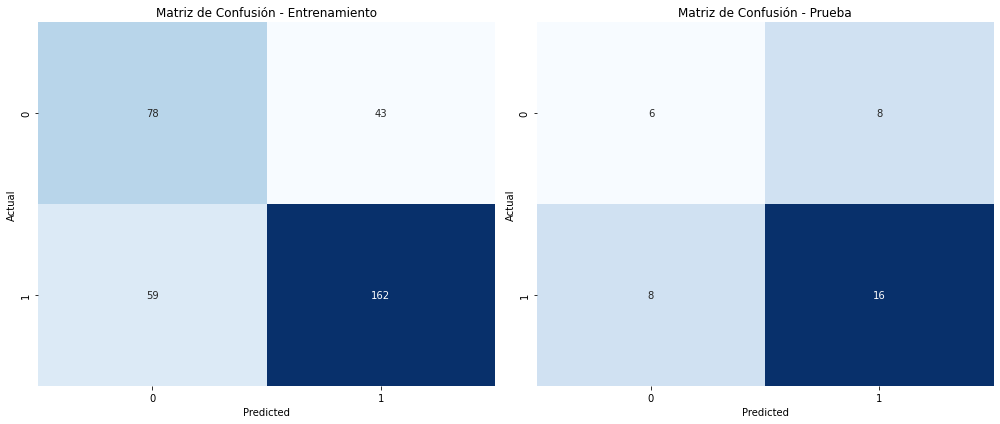

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble4)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble4)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.4.3 SVM

In [ ]:
# Definimos el modelo
start_time = time.time()
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# se ajusta el modelo
svm.fit(Xtv1, ytv1)
tiempo_fit_svm = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble5 = BaggingClassifier(base_estimator=svm, n_estimators=50, random_state=42)

# Entrenamos el ensamble
ensamble5.fit(Xtv1, ytv1)
tiempo_fit_ensamble5 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble5 = ensamble5.predict(Xtv1)
recall_tv_ensamble5 = recall_score(ytv1, ytv_pred_ensamble5, average='binary')
recall_tv_macro_ensamble5 = recall_score(ytv1, ytv_pred_ensamble5, average='macro')
f1_tv_ensamble5 = f1_score(ytv1, ytv_pred_ensamble5, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'svm', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble5],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble5],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble5],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_svm,tiempo_fit_ensamble5]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble5 = ensamble5.predict(Xtest1)
recall_test_ensamble5 = recall_score(ytest1, ytest_pred_ensamble5, average='binary')
recall_test_macro_ensamble5 = recall_score(ytest1, ytest_pred_ensamble5, average='macro')
f1_test_ensamble5 = f1_score(ytest1, ytest_pred_ensamble5, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'svm', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble5],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble5],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble5],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_svm,tiempo_fit_ensamble5]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,1.000000,0.504132,0.786477,0.709989
Dummy,0.000000,0.000000,0.774194,0.000291
svm,0.610860,0.623612,0.675000,0.078416
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Ensemble,1.000000,0.500000,0.774194,0.709989
svm,0.666667,0.511905,0.653061,0.078416


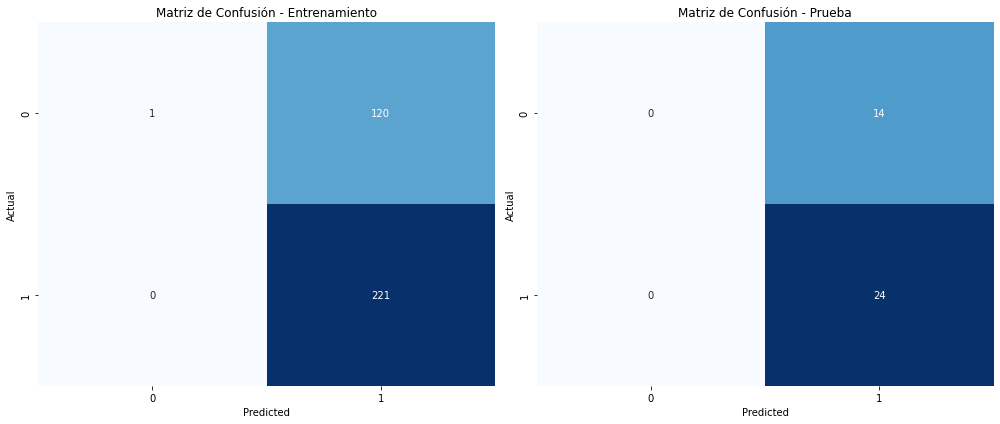

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble5)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble5)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.4.4 Red Neuronal

In [ ]:
# Definimos el modelo
start_time = time.time()
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=42)

# se ajusta el modelo
red.fit(Xtv2, ytv2)
tiempo_fit_red = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble6 = BaggingClassifier(base_estimator=red, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble6.fit(Xtv2, ytv2)
tiempo_fit_ensamble6 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv = recall_score(ytv2, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv_pred, average='macro')
f1_tv = f1_score(ytv2, ytv_pred, average='binary')

ytv_pred_ensamble6 = ensamble6.predict(Xtv2)
recall_tv_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='binary')
recall_tv_macro_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='macro')
f1_tv_ensamble6 = f1_score(ytv2, ytv_pred_ensamble6, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble6],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test = recall_score(ytest2, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest_pred, average='macro')
f1_test = f1_score(ytest2, ytest_pred, average='binary')

ytest_pred_ensamble6 = ensamble6.predict(Xtest2)
recall_test_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='binary')
recall_test_macro_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='macro')
f1_test_ensamble6 = f1_score(ytest2, ytest_pred_ensamble6, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble6],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,1.000000,0.995868,0.997743,43.797074
Dummy,0.000000,0.000000,0.774194,0.000291
red neuronal,0.692308,0.523840,0.676991,0.346904
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.000291
Ensemble,0.791667,0.610119,0.745098,43.797074
red neuronal,0.625000,0.455357,0.612245,0.346904


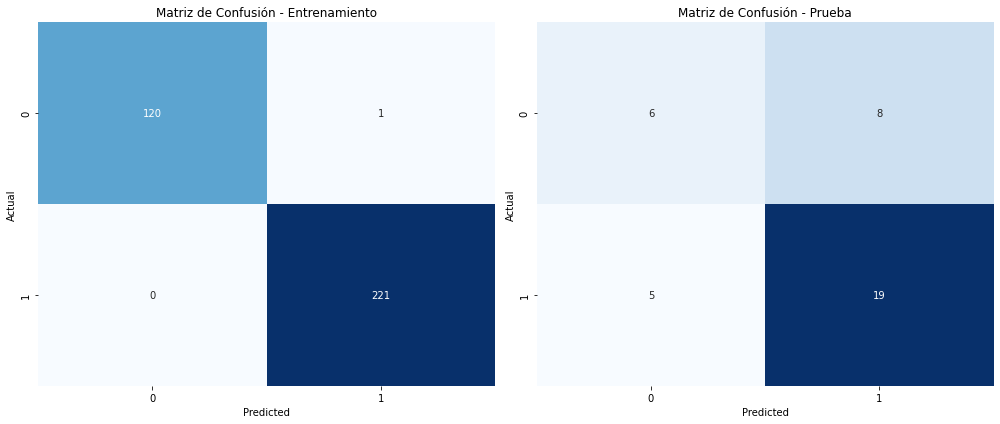

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv2, ytv_pred_ensamble6)
cm_test = confusion_matrix(ytest2, ytest_pred_ensamble6)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### **2.5 Conclusiones**

In [ ]:
# Comparativa todos de los 9 modelos de ensamble

cuadro = {
    'Modelo': ['Dummy','ETC', 'GBC','ABC','Ens_1', 'Ens_2','Ens_3','Ens_4','Ens_5','Ens_6'],
    'R_Trn': [recall_test_dum, recall_tv_etc,recall_tv_gbc,recall_tv_abc,
              recall_tv_ensamble1,recall_tv_ensamble2,recall_tv_ensamble3,
              recall_tv_ensamble4,recall_tv_ensamble5,recall_tv_ensamble6],

    'R_Tst': [recall_test_dum, recall_test_etc,recall_test_gbc,recall_test_abc,
              recall_test_ensamble1,recall_test_ensamble2,recall_test_ensamble3,
              recall_test_ensamble4,recall_test_ensamble5,recall_test_ensamble6],

    'RM_Trn': [recall_test_macro_dum, recall_tv_macro_etc,recall_tv_macro_gbc,recall_tv_macro_abc,
               recall_tv_macro_ensamble1,recall_tv_macro_ensamble2,
               recall_tv_macro_ensamble3,recall_tv_macro_ensamble4,recall_tv_macro_ensamble5,
               recall_tv_macro_ensamble6],

    'RM_Tst': [recall_test_macro_dum, recall_test_macro_etc,recall_test_macro_gbc,recall_test_macro_abc,
               recall_test_macro_ensamble1,recall_test_macro_ensamble2,recall_test_macro_ensamble3,
               recall_test_macro_ensamble4,recall_test_macro_ensamble5,recall_test_macro_ensamble6],

    'F1_Trn': [f1_test_dum, f1_tv_etc,f1_tv_gbc,f1_tv_abc,f1_tv_ensamble1,f1_tv_ensamble2,
               f1_tv_ensamble3,f1_tv_ensamble4,f1_tv_ensamble5,f1_tv_ensamble6],

    'F1_Tst': [f1_test_dum, f1_test_etc,f1_test_gbc,f1_test_abc,f1_test_ensamble1,f1_test_ensamble2,
               f1_test_ensamble3,f1_test_ensamble4,f1_test_ensamble5,f1_test_ensamble6]
}

# Convertir el diccionario en un DataFrame, utilizando la columna 'Index' como índice
models_test_comp_df = pd.DataFrame(cuadro, index=cuadro['Modelo'])*100

# Eliminar la columna 'Index' del DataFrame, si se desea
models_test_comp_df.drop(columns=['Modelo'], inplace=True)

# Resaltar los valores máximos en cada fila
models_test_comp_df.style.highlight_max(color='lightblue', axis=0)

,R_Trn,R_Tst,RM_Trn,RM_Tst,F1_Trn,F1_Tst
Dummy,0.000000,0.000000,0.000000,0.000000,77.419355,77.419355
ETC,77.375566,70.833333,53.150593,49.702381,71.548117,66.666667
GBC,75.565611,58.333333,53.485285,43.452381,70.912951,58.333333
ABC,71.040724,54.166667,53.702180,48.511905,69.010989,57.777778
Ens_1,87.782805,79.166667,64.139337,53.869048,79.671458,71.698113
Ens_2,99.547511,70.833333,98.120863,49.702381,98.876404,66.666667
Ens_3,86.425339,58.333333,86.187876,50.595238,89.044289,60.869565
Ens_4,73.303167,66.666667,68.882989,54.761905,76.056338,66.666667
Ens_5,100.000000,100.000000,50.413223,50.000000,78.647687,77.419355
Ens_6,100.000000,79.166667,99.586777,61.011905,99.774266,74.509804


Para discutir las conclusiones, nos centraremos en el Recall, que, al final del día, es la métrica más relevante para este tipo de análisis. Sin embargo, también consideraremos el Recall Macro y el F1 Score.

Al observar los resultados anteriores, es evidente que los modelos GBC, ABC, Ensamble 2, Ensamble 3, Ensamble 5 y Ensamble 6 están notablemente sobreajustados, por lo que los descartaremos de inmediato. Esto nos deja con los modelos ETC, Ensemble 1, Ensamble 4 y nuestro modelo de referencia, el modelo dummy, para analizar.

Al continuar con nuestro análisis, notamos que el modelo con el mayor Recall en los datos de prueba es el Ensamble 1, con un 79%. Le siguen el modelo ETC con un 71% y el Ensamble 4 con un 67%.

Al examinar el Recall Macro, observamos que la diferencia entre la métrica para el conjunto de entrenamiento y de prueba no es tan pequeña para el modelo Ensamble 4 como lo es para el modelo ETC e incluso el Ensamble 1. Sin embargo, el Recall Macro más alto pertenece al modelo Ensamble 4, aunque no es significativamente superior al del Ensamble 1 como para preferirlo.

Al analizar el F1 Score, observamos que ninguno de los tres modelos supera el F1 del conjunto de prueba con nuestro modelo dummy. Esto indica que nuestros modelos no están prediciendo tan bien la clase Leve como un modelo que solo predice la clase Moderada-Grave, lo cual es preocupante ya que puede sugerir que nuestros modelos están quedando subentrenados. Esto probablemente se debe a la escasez de datos. Sin embargo, podemos destacar que el modelo con el mayor F1 de los tres es el modelo Ensamble 1.

En conclusión, los modelos encontrados con los datos disponibles no proporcionan mucha evidencia de una relación estrecha entre las variables predictoras y la variable objetivo. No obstante, al intentar elegir un mejor modelo, nos inclinaríamos por el modelo Ensamble 1.

### **2.4 Modelos No Supervisados**

Después de tres semanas de exhaustivo análisis de diversas estrategias en modelos no supervisados, lamentablemente no hemos encontrado ninguna solución que muestre un potencial prometedor para abordar nuestro problema de modelización.

Durante este periodo, hemos explorado una variedad de modelos, entre ellos:

K-Means: Probamos este algoritmo con diferentes números de clusters (2 y 3). Sin embargo, los resultados no fueron satisfactorios. Incluso con solo 2 clusters, observamos un Silhouette Score notablemente bajo, indicando una agrupación deficiente de los datos en cualquier número significativo de clusters.

Clustering Jerárquico: Utilizamos diversos métodos de enlace (sencillo, completo, promedio y Ward) en un intento por encontrar estructuras de clusters más cohesivas. Lamentablemente, ninguno de estos métodos produjo resultados prometedores en términos de la separación de clusters.

Para evaluar el desempeño de nuestros modelos, empleamos métricas como el Recall. Aunque uno de los modelos exhibió un Recall del 47%, este valor no alcanza para considerarlo una solución viable para nuestro proyecto.

Dada la falta de resultados significativos, hemos decidido interrumpir la exploración de modelos no supervisados en este momento. En lugar de ello, nos enfocaremos en explorar modelos supervisados que puedan proporcionar un rendimiento más sólido y prometedor.

### **2.5 Características relevantes**

#### 2.5.1 Opción 1

Una primera opción podría ser, utilizar el primer ensamble, que obtuvo un buen rendimiento en cuanto a recall, y fijarnos en los coeficientes obtenidos en la regresión. Ya que, el signo y magnitud del coeficiente de una característica (y manteniendo fijas el resto de variables), indica el cambio en la sintomatología ansiosa con respecto al cambio en dicha característica. Y dado que al codificar la variable de síntomas ansiosos tenemos 0 y 1 para leve y moderado-grave respectivamente, podríamos indicar que un coeficiente positivo y mayor de 0.5 indicaría que está ligado a una sintomatología ansiosa mayor. En cambio, un coeficiente negativo y menor a -0.5, indicaría que esa característica está ligada a una sintomatología ansiosa menor.

In [ ]:
nombres = Xtv1.columns.tolist()

coeficientes_reg = reg.coef_[0]
coeficientes_caracteristicas_reg = dict(zip(nombres, coeficientes_reg))
importantes_reg = sorted(coeficientes_caracteristicas_reg.items(), key=lambda x: abs(x[1]), reverse=True)

print(f'Características más importantes de la regresión:\n')
for caracteristica, promedio in importantes_reg[:10]:
    print(f'{caracteristica}: {promedio}')

Características más importantes de la regresión:

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.8870097344346984
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8215803095112284
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.7453681935128227
RELIGION_Ateo: -0.6533150527590478
A3f_DIFICULTAD_CONCENTRACION: -0.5606644974773992
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5202259114052454
PROVEEDOR_FAMILIAR_Paciente: -0.5178313975620302
A3e_SINTO_INUTIL_CULPABLE: 0.49725491990819615
ESTADO_civil_Divorciado(a): 0.47490898416474875
RELIGION_Ninguna: 0.47272668819271574


#### 2.5.2 Opción 2

Otra opción viable, puede ser enfocarnos en los 3 mejores modelos y observar las características que más aportaron a cada uno de ellos. Obtener este conjunto de datos, podría robustecer el análisis sobre cuales variables guardan una mayor relación con respecto a los síntomas ansiosos

Primero obtenemos las características más relevantes de la regresión y SVM que se utilizó en el primer ensamble y posteriormente, las más relevantes usando el promedio de los coeficientes

In [ ]:
nombres = Xtv1.columns.tolist()

coeficientes_reg = reg.coef_[0]
coeficientes_caracteristicas_reg = dict(zip(nombres, coeficientes_reg))
importantes_reg = sorted(coeficientes_caracteristicas_reg.items(), key=lambda x: abs(x[1]), reverse=True)


coeficientes_svm = svm.coef_[0]
coeficientes_caracteristicas_svm = dict(zip(nombres, coeficientes_svm))
importantes_svm = sorted(coeficientes_caracteristicas_svm.items(), key=lambda x: abs(x[1]), reverse=True)

promedio_importancias_reg = {nombre: (coef_reg + coef_svm) / 2
                             for (nombre, coef_reg), (_, coef_svm)
                             in zip(importantes_reg, importantes_svm)}

importantes_promedio = sorted(promedio_importancias_reg.items(), key=lambda x: abs(x[1]), reverse=True)

print(f'Características más importantes de la regresión:\n')
for caracteristica, promedio in importantes_reg[:10]:
    print(f'{caracteristica}: {promedio}')

print(f'\nCaracterísticas más importantes de SVM:\n')
for caracteristica, promedio in importantes_svm[:10]:
    print(f'{caracteristica}: {promedio}')

print(f'\nCaracterísticas más importantes promediando ambos:\n')
for caracteristica, promedio in importantes_promedio[:10]:
    print(f'{caracteristica}: {promedio}')

Características más importantes de la regresión:

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.8870097344346984
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8215803095112284
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.7453681935128227
RELIGION_Ateo: -0.6533150527590478
A3f_DIFICULTAD_CONCENTRACION: -0.5606644974773992
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5202259114052454
PROVEEDOR_FAMILIAR_Paciente: -0.5178313975620302
A3e_SINTO_INUTIL_CULPABLE: 0.49725491990819615
ESTADO_civil_Divorciado(a): 0.47490898416474875
RELIGION_Ninguna: 0.47272668819271574

Características más importantes de SVM:

CONDICION_ACTUAL_encoded: 0.21934301312890558
ESCOLARIDAD_MAXIMA_PX_encoded: -0.18840731343364656
TRASTORNO_MAYOR_DIAGNOSTICO_encoded: 0.17798669742901463
Riesgo_suicidio_encoded: 0.15622503405000712
OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.1396596985901799
DX_PRIMARIO_encoded: 0.1364212546243236
AnioS_ESTUDIO_PACIENTE: 0.11492572589500398

Ahora obtenemos las características más importantes obtenidas con el cuarto ensamble

In [ ]:
coeficientes_ensamble = np.mean([estimator.coef_ for estimator in ensamble4.estimators_], axis=0)
coeficientes_caracteristicas = dict(zip(nombres, coeficientes_ensamble[0]))
importantes = sorted(coeficientes_caracteristicas.items(), key=lambda x: abs(x[1]), reverse=True)

for caracteristica, coeficiente in importantes[:10]:
    print(f'{caracteristica}: {coeficiente}')

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.9707999129088516
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8517030614392573
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.682927994054282
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5302154450975439
ESTADO_civil_Divorciado(a): 0.5283743741813501
ESCOLARIDAD_MAXIMA_PX_encoded: -0.5236955370448607
PROVEEDOR_FAMILIAR_Paciente: -0.5203244841733565
PROVEEDOR_FAMILIAR_Otro: 0.48191731383072933
RELIGION_Ateo: -0.48166779734487514
A3f_DIFICULTAD_CONCENTRACION: -0.4809794863957344


Finalmente, hacemos lo mismo para el sexto ensamble

In [ ]:
estimadores_red = ensamble6.estimators_

pesos_ultima_capa = []

for estimador in estimadores_red:
    pesos_ultima_capa.append(estimador.coefs_[-2])

pesos_promedio = np.mean(pesos_ultima_capa, axis=0)

importancia_caracteristicas = []

for peso in pesos_promedio:
    importancia_caracteristicas.append(np.abs(peso).mean())

nombres = Xtv2.columns.tolist()

importancia_caracteristicas = dict(zip(nombres, importancia_caracteristicas))

importantes = sorted(importancia_caracteristicas.items(), key=lambda x: x[1], reverse=True)

for caracteristica, importancia in importantes[:10]:
    print(f'{caracteristica}: {importancia}')

ESTADO_civil: 0.029845889225072336
OCUPACIoN_JEFE_FAMILIA: 0.02413797827084077
TRASTORNO_MAYOR_DIAGNOSTICO_encoded: 0.022818633868402004
ESCOLARIDAD__JEFE_FAMILIA_encoded: 0.021471773128318838
PROVEEDOR_FAMILIAR: 0.02065463245962348
CONDICION_ACTUAL_encoded: 0.020494570245468084
Riesgo_suicidio_encoded: 0.019544847507270095
ESCOLARIDAD_MAXIMA_PX_encoded: 0.01952920131025861
AnioS_ESTUDIO_PACIENTE: 0.016000690640210546
A3g_PENSAMIENTO_INTENCION_SUICIDIO: 0.015739094364938856


Omitiendo las características repetidas, tenemos:

 "A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION", "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO", "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded", "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded", "ESTADO_civil", "ESTADO_civil_Divorciado(a)", "ESTADO_civil_Separado(a)", "ESTADO_civil_Viudo(a)", "OCUPACIoN_JEFE_FAMILIA", "OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual", "OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana", "OCUPACIoN_JEFE_FAMILIA_No determinado", "OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria", "PROVEEDOR_FAMILIAR", "PROVEEDOR_FAMILIAR_Otro", "PROVEEDOR_FAMILIAR_Paciente", "RELIGION_Ateo", "RELIGION_Catolica", "RELIGION_Ninguna", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded"

 En el pre-procesamiento de la base, se generaron dummies de algunas características, por lo que si nos quedamos con la característica original, la lista se reduce a:

 "A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION", "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO", "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded", "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded", "ESTADO_civil", "OCUPACIoN_JEFE_FAMILIA", "PROVEEDOR_FAMILIAR", "RELIGION", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded"

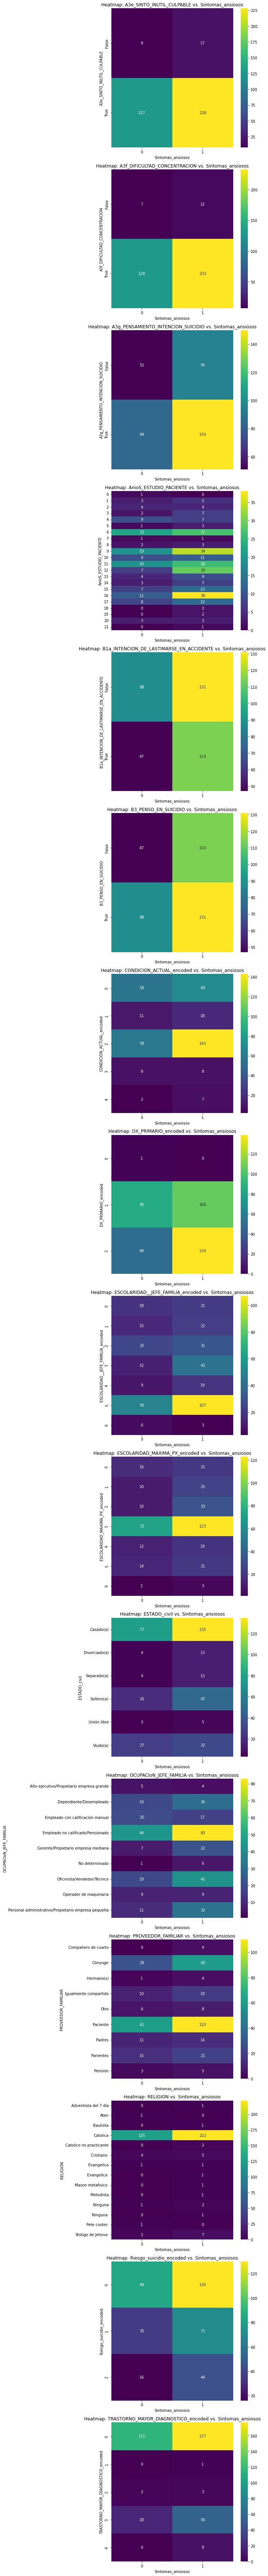

In [ ]:
variables = df_TC[["A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION",
                     "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE",
                     "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO",
                     "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded",
                     "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded",
                     "ESTADO_civil", "OCUPACIoN_JEFE_FAMILIA", "PROVEEDOR_FAMILIAR",
                     "RELIGION", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded","Sintomas_ansiosos_encoded"]].columns[:-1]

# Crea una nueva figura para mostrar los heatmaps
plt.figure(figsize=(10, 6 * len(variables)))

# Itera sobre cada variable categórica y crea un heatmap
for i, variable in enumerate(variables):
    tabla_contingencia = pd.crosstab(df_TC[variable], df_TC['Sintomas_ansiosos_encoded'])
    plt.subplot(len(variables), 1, i + 1)
    sns.heatmap(tabla_contingencia, cmap='viridis', annot=True, fmt='d')
    plt.title(f'Heatmap: {variable} vs. Sintomas_ansiosos')
    plt.xlabel('Sintomas_ansiosos')
    plt.ylabel(variable)

# Ajusta el espacio entre los heatmaps
plt.tight_layout()

# Muestra los heatmaps uno debajo del otro
plt.show()